In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import h5py
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import random
from sklearn import svm

In [2]:
fly_selected_name_1 = '20230420-nsyb-G7f-rAch1h/fly2/data_motion'
file_save_path = 'motion_analysis'
# motion data
motion_result_path = '../../../results/3.odor_random_90_times_OCT_MCH_EA_new/nsyb-G7f-rAch1h'
light_filename = 'light_trace_thresh.mat'
mean_motion_filename = 'fly_trace_diff_mean_notch_adjusted.mat'
motion_filename = 'fly_trace_diff_adjusted.mat'
# neural data
fly_selected_name_2 = 'Ach-ver16/20230420-fly2'
neural_result_path = '../results'
channel_1_path = 'voxel-integration-region-SRD-long-formal/channel_1_response_thresh_0.7_pca_thresh_0.9_block_size_0.1_odor_choice_0_downsample/pca_projection.npy'
channel_2_path = 'voxel-integration-region-SRD-long-formal/channel_2_response_thresh_0.7_pca_thresh_0.9_block_size_0.1_odor_choice_0_downsample/pca_projection.npy'
# parameters
num_frame_trash = 1000
frame_rate_motion = 30
frame_rate_neural = 15/13
win_motion = 13 #s
num_tp_neural = 43
num_trial = 180
win_stim = 5 #s
stim = np.array([3,1,2,3,2,1,3,1,2,1,2,3,1,2,3,2,3,1,3,2,1,2,3,1,2,3,1,2,1,3,2,3,1,2,3,1,3,1,2,3,1,2,3,2,1,2,1,3,2,1,3,1,2,3,1,2,3,2,1,3,1,2,3,2,1,3,1,3,2,3,2,1,3,2,1,3,1,2,3,2,1,3,1,2,3,2,1,2,3,1,
                 3,1,2,3,1,2,3,2,1,2,3,1,2,1,3,2,1,3,1,3,2,3,1,2,1,2,3,2,3,1,2,3,1,3,2,1,2,3,1,2,1,3,1,2,3,2,3,1,2,1,3,1,3,2,3,1,2,1,2,3,2,1,3,1,2,3,2,3,1,3,1,2,1,3,2,1,3,2,3,1,2,3,2,1,2,1,3,1,2,3])
dim_pca = 50
the_save_path = os.path.join(motion_result_path,fly_selected_name_1,file_save_path)
folder = os.path.exists(the_save_path)
if not folder:
    os.makedirs(the_save_path)

In [3]:
# load data
# motion
f = os.path.join(motion_result_path,fly_selected_name_1)
data = h5py.File(os.path.join(f,light_filename))
data_light = np.squeeze(data['trace_processed'])
data_light = data_light[1:]
data_light = data_light[num_frame_trash:]
data = h5py.File(os.path.join(f,mean_motion_filename))
data_mean_motion = np.squeeze(data['trace_filtered'])
data_mean_motion = data_mean_motion[num_frame_trash:]
data_mean_motion = (data_mean_motion-np.min(data_mean_motion))/(np.max(data_mean_motion)-np.min(data_mean_motion)) ## 0-1
data = h5py.File(os.path.join(f,motion_filename))
data_motion = np.squeeze(data['motion'])
data_motion = data_motion[:,:,num_frame_trash:]
print('motion data loaded!')
print(np.shape(data_light))
print(np.shape(data_mean_motion))
print(np.shape(data_motion))
# neural data
f = os.path.join(neural_result_path,fly_selected_name_2)
neural_channel_1 = np.load(os.path.join(f,channel_1_path))
neural_channel_2 = np.load(os.path.join(f,channel_2_path))
print('neural data loaded!')
print(np.shape(neural_channel_1))
print(np.shape(neural_channel_2))

motion data loaded!
(245486,)
(245486,)
(111, 81, 245486)
neural data loaded!
(7740, 2520)
(7740, 2520)


pearson: 0.14094301966790132
P-Value: 0.0
shuffle
pearson: -0.0014973581447811437
P-Value: 0.4581565016341665
[[0.14094301966790132, 0.0], [-0.0014973581447811437, 0.4581565016341665]]


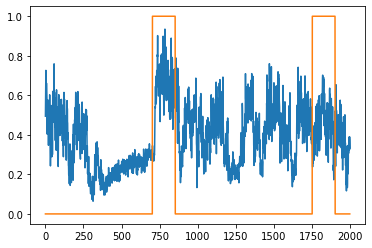

In [4]:
# 1.corr-morion energy and stim
# original data
r = stats.pearsonr(data_light,data_mean_motion)
print("pearson:",r[0])
print("P-Value:",r[1])
r_1 = []
r_1.append([r[0],r[1]])
a = data_mean_motion.copy()
random.shuffle(a)
r = stats.pearsonr(data_light,a)
print('shuffle')
print("pearson:",r[0])
print("P-Value:",r[1])
r_1.append([r[0],r[1]])
print(r_1)
np.save(os.path.join(the_save_path,'corr_motion_stim.npy'),r_1)
plt.plot(data_mean_motion[30000:32000])
plt.plot(data_light[30000:32000])
plt.show()

In [5]:
## pca-time window
h = np.size(data_motion,0)
w = np.size(data_motion,1)
# stim-rising edge
win = win_motion*frame_rate_motion
data_motion_reshape = np.zeros((h*w,win,num_trial))
light_reshape = np.zeros((win,num_trial))
data_mean_motion_reshape = np.zeros((win,num_trial))
flag = 0
for i in range(1,len(data_light)):
    if data_light[i]==1 and data_light[i-1]==0:
        # print('stim:'+str(flag)) 
        a = data_motion[:,:,i:i+win]
        data_motion_reshape[:,:,flag] = a.reshape((-1,win),order = 'F')
        light_reshape[:,flag] = data_light[i:i+win]
        data_mean_motion_reshape[:,flag] = data_mean_motion[i:i+win]
        flag = flag+1
print('stim:'+str(flag))
# pca 
data_motion_reshape_2 = np.transpose(data_motion_reshape,[1,2,0])
# match temporal resolution: motion and neural data
data_motion_reshape_2= data_motion_reshape_2[0::26,:,:]####
light_reshape_try = light_reshape[0::26,:]####
mean_motion_reshape_try = data_mean_motion_reshape[0::26,:]####
print(np.shape(data_motion_reshape_2))
print(np.shape(light_reshape_try))
print(np.shape(mean_motion_reshape_try))
win = np.size(data_motion_reshape_2,0)
data_motion_reshape_2 = data_motion_reshape_2.reshape((win*num_trial,-1),order = 'F')
data_motion_reshape_2 = scale(X=data_motion_reshape_2,with_mean=True,with_std=True,copy=True)
pca = PCA(n_components=dim_pca)
pca.fit(data_motion_reshape_2)
motion_pca = pca.transform(data_motion_reshape_2)
print(np.shape(motion_pca))

stim:180
(15, 180, 8991)
(15, 180)
(15, 180)
(2700, 50)


(50, 8991)


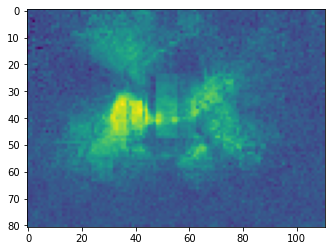

(15, 180, 50)


In [6]:
# save components and transform results
print(np.shape(pca.components_))
a = pca.components_
a = np.squeeze(a[0,:])
a = a.reshape((h,w),order = 'F')
a = np.transpose(a,[1,0])
plt.imshow(a)
plt.show()
np.save(os.path.join(the_save_path,'pca_components.npy'),pca.components_)
motion_pca_save = motion_pca.reshape((win,num_trial,-1),order = 'F')
print(np.shape(motion_pca_save))
np.save(os.path.join(the_save_path,'pca_transformed.npy'),motion_pca_save)

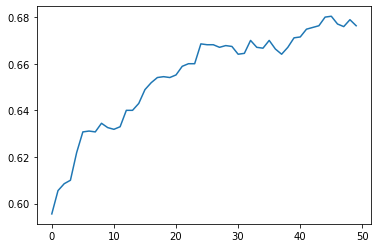

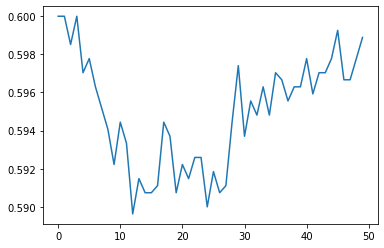

(2, 50)


In [7]:
# motion-classification
# odor stimulation and the resting state
list_acc_stim_1 = np.zeros(dim_pca)
label = light_reshape_try.reshape(-1,order = 'F')
for i in range(dim_pca):
    motion_pca_svm = motion_pca[:,range(i+1)]
    clf = svm.SVC()
    kf = KFold(n_splits=5, random_state=5, shuffle=True)
    acc = np.mean(cross_val_score(clf, motion_pca_svm, label, scoring='accuracy', cv=kf))
    list_acc_stim_1[i] = acc
plt.plot(list_acc_stim_1)
plt.show()
# shuffle
list_acc_stim_2 = np.zeros(dim_pca)
label = light_reshape_try.reshape(-1,order = 'F')
label_2 = label.copy()
random.shuffle(label_2)
for i in range(dim_pca):
    motion_pca_svm = motion_pca[:,range(i+1)]
    clf = svm.SVC()
    kf = KFold(n_splits=5, random_state=5, shuffle=True)
    acc = np.mean(cross_val_score(clf, motion_pca_svm, label_2, scoring='accuracy', cv=kf))
    list_acc_stim_2[i] = acc
plt.plot(list_acc_stim_2)
plt.show()

# save classification results
list_acc_stim = np.stack((list_acc_stim_1,list_acc_stim_2))
print(np.shape(list_acc_stim))
np.save(os.path.join(the_save_path,'stim_classification_accuracy.npy'),list_acc_stim)

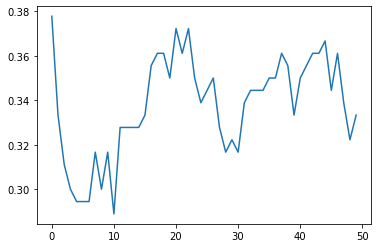

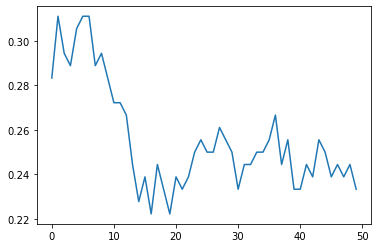

(2, 50)


In [8]:
# motion-classification
# odor identity
list_acc_odor_1 = np.zeros(dim_pca)
for i in range(dim_pca):
    motion_pca_svm = motion_pca_save[:,:,range(i+1)]
    motion_pca_svm = motion_pca_svm[range(int(win_stim*frame_rate_neural)),:,:]
    if motion_pca_svm.ndim == 3:
        motion_pca_svm = np.transpose(motion_pca_svm,[1,0,2])
    else:
        motion_pca_svm = np.transpose(motion_pca_svm,[1,0])
    motion_pca_svm = motion_pca_svm.reshape((num_trial,-1),order = 'F')
    x_svm = scale(X=motion_pca_svm,with_mean=True,with_std=True,copy=True)
    pca = PCA()
    x_svm = pca.fit_transform(x_svm)
    clf = svm.SVC()
    kf = KFold(n_splits=5, random_state=5, shuffle=True)
    acc = np.mean(cross_val_score(clf, x_svm, stim, scoring='accuracy', cv=kf))
    list_acc_odor_1[i] = acc
plt.plot(list_acc_odor_1)
plt.show()
# shuffle
stim_2 = stim.copy()
random.shuffle(stim_2)
list_acc_odor_2 = np.zeros(dim_pca)
for i in range(dim_pca):
    motion_pca_svm = motion_pca_save[:,:,range(i+1)]
    motion_pca_svm = motion_pca_svm[range(int(win_stim*frame_rate_neural)),:,:]
    if motion_pca_svm.ndim == 3:
        motion_pca_svm = np.transpose(motion_pca_svm,[1,0,2])
    else:
        motion_pca_svm = np.transpose(motion_pca_svm,[1,0])
    motion_pca_svm = motion_pca_svm.reshape((num_trial,-1),order = 'F')
    x_svm = scale(X=motion_pca_svm,with_mean=True,with_std=True,copy=True)
    pca = PCA()
    x_svm = pca.fit_transform(x_svm)
    clf = svm.SVC()
    kf = KFold(n_splits=5, random_state=5, shuffle=True)
    acc = np.mean(cross_val_score(clf, x_svm, stim_2, scoring='accuracy', cv=kf))
    list_acc_odor_2[i] = acc
plt.plot(list_acc_odor_2)
plt.show()

# save classification results
list_acc_odor = np.stack((list_acc_odor_1,list_acc_odor_2))
print(np.shape(list_acc_odor))
np.save(os.path.join(the_save_path,'odor_classification_accuracy.npy'),list_acc_odor)

channel-0
(15, 180, 2520)
(15, 180, 50)
(15, 180, 2520)
neural pc-0


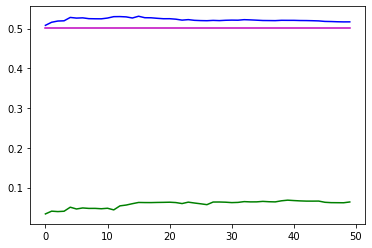

neural pc-1


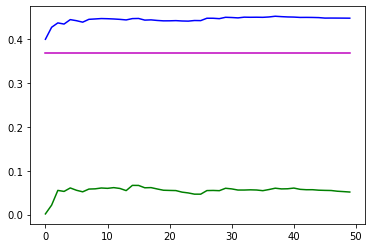

neural pc-2


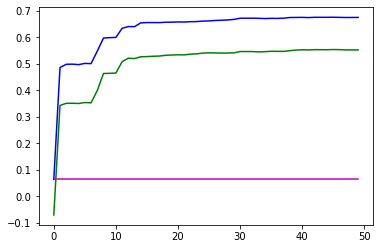

neural pc-3


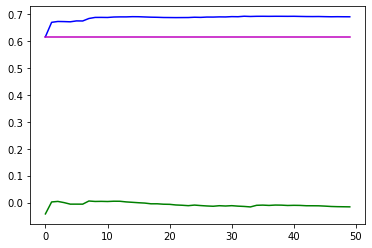

neural pc-4


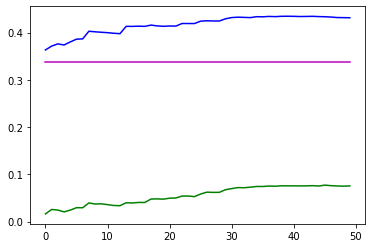

channel-1
(15, 180, 2520)
(15, 180, 50)
(15, 180, 2520)
neural pc-0


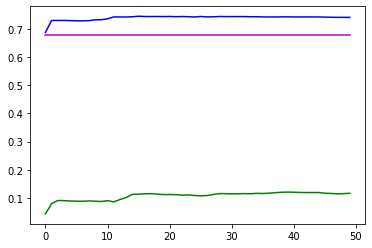

neural pc-1


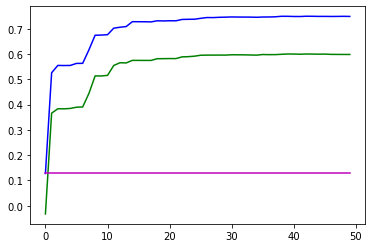

neural pc-2


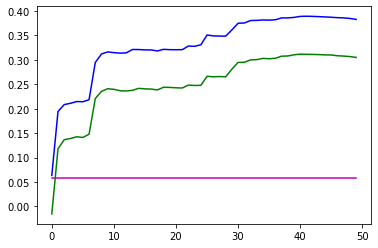

neural pc-3


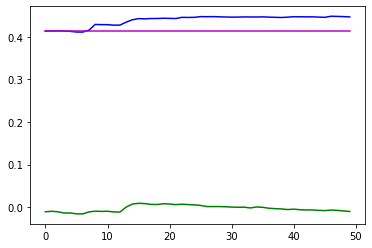

neural pc-4


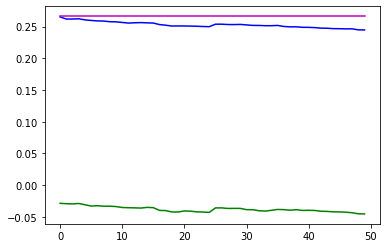

In [9]:
# regression: neural dynamics
kf = KFold(n_splits=5, random_state=5, shuffle=True)
for ii in range(2):
    print('channel-'+str(ii))
    if ii == 0:
        # c1
        data_neuron_pca_try = neural_channel_1.reshape((num_tp_neural,num_trial,-1),order = 'F')
    else:
        # c2
        data_neuron_pca_try = neural_channel_2.reshape((num_tp_neural,num_trial,-1),order = 'F')
    motion_pca_try = motion_pca.reshape((win,num_trial,-1),order = 'F')
    # match time window
    data_neuron_pca_try = data_neuron_pca_try[3:18,:,:]####
    print(np.shape(data_neuron_pca_try))
    win_new = np.size(motion_pca_try,0)
    # ridge regression
    clf = Ridge(alpha=1.0)
    kf = KFold(n_splits=5, random_state=5, shuffle=True)
    X = motion_pca_try
    y = data_neuron_pca_try
    print(np.shape(X))
    print(np.shape(y))
    stim_kind = np.unique(stim)
    label_list = data_neuron_pca_try.copy()
    for j in range(len(stim_kind)):
        a = np.mean(data_neuron_pca_try[:,stim==stim_kind[j],:],1)
        inds = np.where(stim==stim_kind[j])
        inds = inds[0]
        for k in inds:
            label_list[:,k,:] = a

    # take different dimensions of motion pc to fit each dimension of neural pc 
    max_y_dim = 30   ###
    max_x_dim = dim_pca
    acc_list = np.zeros((max_y_dim,max_x_dim,3))
    y_pred_list = np.zeros((max_y_dim,max_x_dim,3,5,int(num_trial/5*win_new),2))
    test_label = np.zeros((5,int(num_trial/5)))
    for i in range(max_y_dim):
        label = np.squeeze(label_list[:,:,i])
        the_y = np.squeeze(y[:,:,i])
        for j in range(0,max_x_dim):
            the_X = X[:,:,range(j+1)]
            the_acc = np.zeros((3,5))
            flag = 0
            for train, test in kf.split(np.linspace(0,num_trial-1,num_trial)):
                train_origin = (np.array(train)).astype(int)
                test_origin = (np.array(test)).astype(int)
                test_label[flag,:] = test_origin

                X_train = the_X[:,train_origin,:]
                label_train = label[:,train_origin]
                y_train = the_y[:,train_origin]
                X_test = the_X[:,test_origin,:]
                label_test = label[:,test_origin]
                y_test = the_y[:,test_origin]

                len_train = len(train_origin)
                len_test = len(test_origin)

                X_train = X_train.reshape((win*len_train,-1),order = 'F')
                label_train = label_train.reshape(-1,order = 'F')
                y_train = y_train.reshape(-1,order = 'F')
                label_train = label_train[:,np.newaxis]
                the_X1_train = np.concatenate((label_train,X_train),axis = 1)
                X_test = X_test.reshape((win*len_test,-1),order = 'F')
                label_test = label_test.reshape(-1,order = 'F')
                y_test = y_test.reshape(-1,order = 'F')
                label_test = label_test[:,np.newaxis]
                the_X1_test = np.concatenate((label_test,X_test),axis = 1)
                
                # X1 - all
                clf.fit(the_X1_train, y_train)
                y_predict = clf.predict(the_X1_test)
                score = clf.score(the_X1_test,y_test)
                the_acc[0,flag] = score
                y_pred_list[i,j,0,flag,:,0] = y_predict
                y_pred_list[i,j,0,flag,:,1] = y_test
                # X - motion
                clf.fit(X_train, y_train)
                y_predict = clf.predict(X_test)
                score = clf.score(X_test,y_test)
                the_acc[1,flag] = score
                y_pred_list[i,j,1,flag,:,0] = y_predict
                y_pred_list[i,j,1,flag,:,1] = y_test
                # label
                clf.fit(label_train, y_train)
                y_predict = clf.predict(label_test)
                score = clf.score(label_test,y_test)
                the_acc[2,flag] = score
                y_pred_list[i,j,2,flag,:,0] = y_predict
                y_pred_list[i,j,2,flag,:,1] = y_test

                flag = flag+1
            acc_list[i,j,:] = np.mean(the_acc,1)
    # plot and save
    for i in range(5):
        print('neural pc-'+str(i))
        plt.figure()
        color_list = ['b','g','m']
        for k in range(3):
            plt.plot(np.squeeze(acc_list[i,:,k]),color = color_list[k])
        plt.show()    
    if ii == 0:
        np.save(os.path.join(the_save_path,'regression_variance_explained_c1.npy'),acc_list)
        np.save(os.path.join(the_save_path,'y_pred_list_c1.npy'),y_pred_list)
        np.save(os.path.join(the_save_path,'test_label.npy'),test_label)
    else:
        np.save(os.path.join(the_save_path,'regression_variance_explained_c2.npy'),acc_list)
        np.save(os.path.join(the_save_path,'y_pred_list_c2.npy'),y_pred_list)

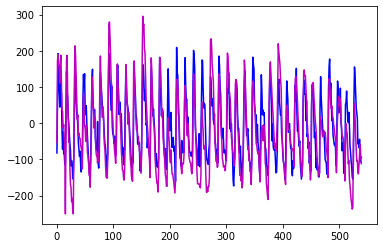

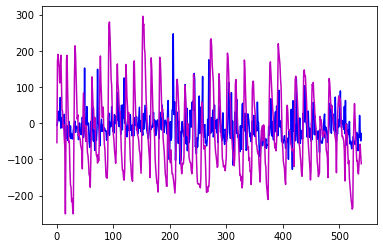

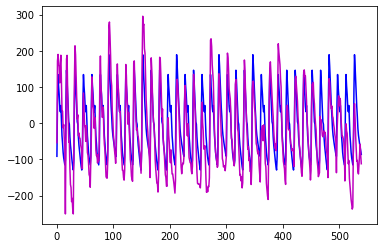

In [10]:
# regression results
y_pred_list = np.load(os.path.join(the_save_path,'y_pred_list_c1.npy'))
for i in range(3):
    y_pred = np.squeeze(y_pred_list[0,49,i,2,:,0])
    y_test = np.squeeze(y_pred_list[0,49,i,2,:,1])
    plt.plot(y_pred,color = 'b')
    plt.plot(y_test,color = 'm')
    plt.show()

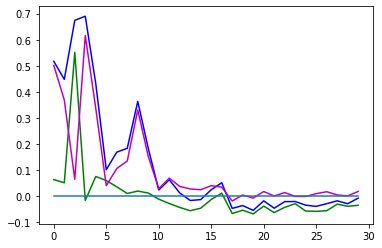

In [11]:
acc = np.load(os.path.join(the_save_path,'regression_variance_explained_c1.npy'))
color_list = ['b','g','m']
for i in range(3):
    plt.plot(np.squeeze(acc[:,49,i]),color = color_list[i])
plt.plot([0,29],[0,0])
plt.show()

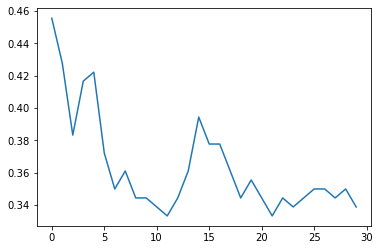

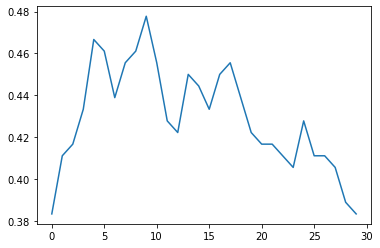

(2, 30)


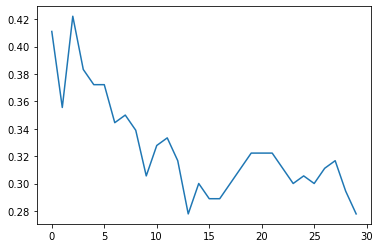

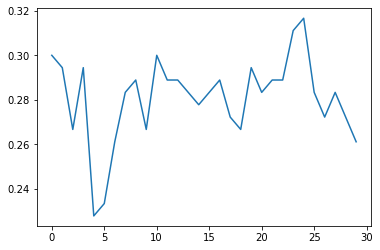

(2, 30)


In [12]:
# classification: neural pc explained by motion
for ii in range(2):
    if ii == 0:
        y_pred_list = np.load(os.path.join(the_save_path,'y_pred_list_c1.npy'))
    else:
        y_pred_list = np.load(os.path.join(the_save_path,'y_pred_list_c2.npy'))
    y_pred = np.squeeze(y_pred_list[:,49,1,:,:,0])
    y_pred_new = np.zeros((max_y_dim,win_new,num_trial))
    for i in range(np.size(test_label,0)):
        the_ind = (np.squeeze(test_label[i,:])).astype(int)
        y_pred_new[:,:,the_ind] = (y_pred[:,i,:]).reshape((max_y_dim,win_new,len(the_ind)),order = 'F')
    y_pred_new = np.transpose(y_pred_new,[1,2,0])
    # odor identity
    list_acc_odor_1 = np.zeros(max_y_dim)
    for i in range(max_y_dim):
        motion_pca_svm = y_pred_new[:,:,range(i+1)]
        motion_pca_svm = motion_pca_svm[range(int(win_stim*frame_rate_neural)),:,:]
        if motion_pca_svm.ndim == 3:
            motion_pca_svm = np.transpose(motion_pca_svm,[1,0,2])
        else:
            motion_pca_svm = np.transpose(motion_pca_svm,[1,0])
        motion_pca_svm = motion_pca_svm.reshape((num_trial,-1),order = 'F')
        x_svm = scale(X=motion_pca_svm,with_mean=True,with_std=True,copy=True)
        pca = PCA()
        x_svm = pca.fit_transform(x_svm)
        clf = svm.SVC()
        kf = KFold(n_splits=5, random_state=5, shuffle=True)
        acc = np.mean(cross_val_score(clf, x_svm, stim, scoring='accuracy', cv=kf))
        list_acc_odor_1[i] = acc
    plt.plot(list_acc_odor_1)
    plt.show()
    # shuffle
    stim_2 = stim.copy()
    random.shuffle(stim_2)
    list_acc_odor_2 = np.zeros(max_y_dim)
    for i in range(max_y_dim):
        motion_pca_svm = y_pred_new[:,:,range(i+1)]
        motion_pca_svm = motion_pca_svm[range(int(win_stim*frame_rate_neural)),:,:]
        if motion_pca_svm.ndim == 3:
            motion_pca_svm = np.transpose(motion_pca_svm,[1,0,2])
        else:
            motion_pca_svm = np.transpose(motion_pca_svm,[1,0])
        motion_pca_svm = motion_pca_svm.reshape((num_trial,-1),order = 'F')
        x_svm = scale(X=motion_pca_svm,with_mean=True,with_std=True,copy=True)
        pca = PCA()
        x_svm = pca.fit_transform(x_svm)
        clf = svm.SVC()
        kf = KFold(n_splits=5, random_state=5, shuffle=True)
        acc = np.mean(cross_val_score(clf, x_svm, stim_2, scoring='accuracy', cv=kf))
        list_acc_odor_2[i] = acc
    plt.plot(list_acc_odor_2)
    plt.show()

    # save classification results
    list_acc_odor = np.stack((list_acc_odor_1,list_acc_odor_2))
    print(np.shape(list_acc_odor))
    if ii == 0:
        np.save(os.path.join(the_save_path,'odor_classification_accuracy_motion_explained_c1.npy'),list_acc_odor)
    else:
        np.save(os.path.join(the_save_path,'odor_classification_accuracy_motion_explained_c2.npy'),list_acc_odor)

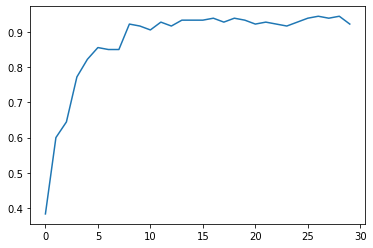

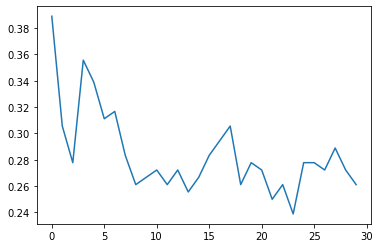

(2, 30)


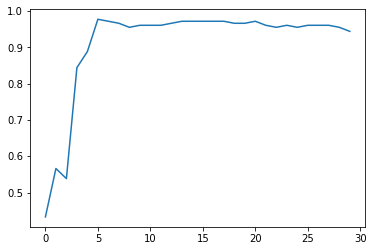

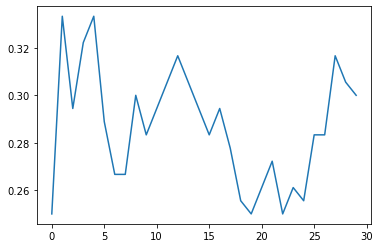

(2, 30)


In [13]:
# classification-neural pc
for ii in range(2):
    if ii == 0:
        y_pred_list = np.load(os.path.join(the_save_path,'y_pred_list_c1.npy'))
    else:
        y_pred_list = np.load(os.path.join(the_save_path,'y_pred_list_c2.npy'))
    y_pred = np.squeeze(y_pred_list[:,49,1,:,:,1])
    y_pred_new = np.zeros((max_y_dim,win_new,num_trial))
    for i in range(np.size(test_label,0)):
        the_ind = (np.squeeze(test_label[i,:])).astype(int)
        y_pred_new[:,:,the_ind] = (y_pred[:,i,:]).reshape((max_y_dim,win_new,len(the_ind)),order = 'F')
    y_pred_new = np.transpose(y_pred_new,[1,2,0])
    # odor identity
    list_acc_odor_1 = np.zeros(max_y_dim)
    for i in range(max_y_dim):
        motion_pca_svm = y_pred_new[:,:,range(i+1)]
        motion_pca_svm = motion_pca_svm[range(int(win_stim*frame_rate_neural)),:,:]
        if motion_pca_svm.ndim == 3:
            motion_pca_svm = np.transpose(motion_pca_svm,[1,0,2])
        else:
            motion_pca_svm = np.transpose(motion_pca_svm,[1,0])
        motion_pca_svm = motion_pca_svm.reshape((num_trial,-1),order = 'F')
        x_svm = scale(X=motion_pca_svm,with_mean=True,with_std=True,copy=True)
        pca = PCA()
        x_svm = pca.fit_transform(x_svm)
        clf = svm.SVC()
        kf = KFold(n_splits=5, random_state=5, shuffle=True)
        acc = np.mean(cross_val_score(clf, x_svm, stim, scoring='accuracy', cv=kf))
        list_acc_odor_1[i] = acc
    plt.plot(list_acc_odor_1)
    plt.show()
    # shuffle
    stim_2 = stim.copy()
    random.shuffle(stim_2)
    list_acc_odor_2 = np.zeros(max_y_dim)
    for i in range(max_y_dim):
        motion_pca_svm = y_pred_new[:,:,range(i+1)]
        motion_pca_svm = motion_pca_svm[range(int(win_stim*frame_rate_neural)),:,:]
        if motion_pca_svm.ndim == 3:
            motion_pca_svm = np.transpose(motion_pca_svm,[1,0,2])
        else:
            motion_pca_svm = np.transpose(motion_pca_svm,[1,0])
        motion_pca_svm = motion_pca_svm.reshape((num_trial,-1),order = 'F')
        x_svm = scale(X=motion_pca_svm,with_mean=True,with_std=True,copy=True)
        pca = PCA()
        x_svm = pca.fit_transform(x_svm)
        clf = svm.SVC()
        kf = KFold(n_splits=5, random_state=5, shuffle=True)
        acc = np.mean(cross_val_score(clf, x_svm, stim_2, scoring='accuracy', cv=kf))
        list_acc_odor_2[i] = acc
    plt.plot(list_acc_odor_2)
    plt.show()

    # save classification results
    list_acc_odor = np.stack((list_acc_odor_1,list_acc_odor_2))
    print(np.shape(list_acc_odor))
    if ii == 0:
        np.save(os.path.join(the_save_path,'odor_classification_accuracy_gt_c1.npy'),list_acc_odor)
    else:
        np.save(os.path.join(the_save_path,'odor_classification_accuracy_gt_c2.npy'),list_acc_odor)

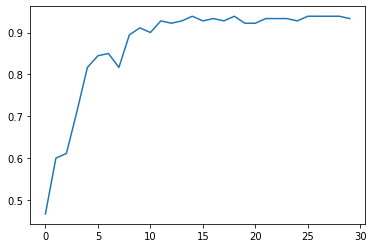

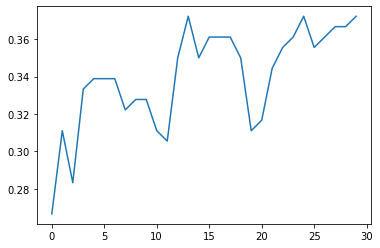

(2, 30)


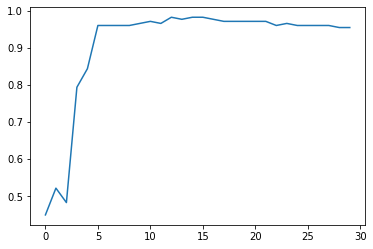

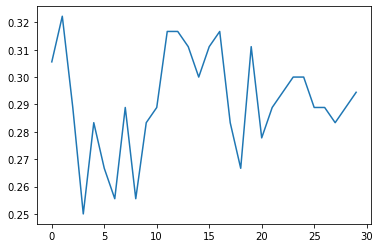

(2, 30)


In [14]:
# classification: neural pc -residual
for ii in range(2):
    if ii == 0:
        y_pred_list = np.load(os.path.join(the_save_path,'y_pred_list_c1.npy'))
    else:
        y_pred_list = np.load(os.path.join(the_save_path,'y_pred_list_c2.npy'))
    y_pred = np.squeeze(y_pred_list[:,49,1,:,:,1])-np.squeeze(y_pred_list[:,49,1,:,:,0])
    y_pred_new = np.zeros((max_y_dim,win_new,num_trial))
    for i in range(np.size(test_label,0)):
        the_ind = (np.squeeze(test_label[i,:])).astype(int)
        y_pred_new[:,:,the_ind] = (y_pred[:,i,:]).reshape((max_y_dim,win_new,len(the_ind)),order = 'F')
    y_pred_new = np.transpose(y_pred_new,[1,2,0])
    # odor identity
    list_acc_odor_1 = np.zeros(max_y_dim)
    for i in range(max_y_dim):
        motion_pca_svm = y_pred_new[:,:,range(i+1)]
        motion_pca_svm = motion_pca_svm[range(int(win_stim*frame_rate_neural)),:,:]
        if motion_pca_svm.ndim == 3:
            motion_pca_svm = np.transpose(motion_pca_svm,[1,0,2])
        else:
            motion_pca_svm = np.transpose(motion_pca_svm,[1,0])
        motion_pca_svm = motion_pca_svm.reshape((num_trial,-1),order = 'F')
        x_svm = scale(X=motion_pca_svm,with_mean=True,with_std=True,copy=True)
        pca = PCA()
        x_svm = pca.fit_transform(x_svm)
        clf = svm.SVC()
        kf = KFold(n_splits=5, random_state=5, shuffle=True)
        acc = np.mean(cross_val_score(clf, x_svm, stim, scoring='accuracy', cv=kf))
        list_acc_odor_1[i] = acc
    plt.plot(list_acc_odor_1)
    plt.show()
    # shuffle
    stim_2 = stim.copy()
    random.shuffle(stim_2)
    list_acc_odor_2 = np.zeros(max_y_dim)
    for i in range(max_y_dim):
        motion_pca_svm = y_pred_new[:,:,range(i+1)]
        motion_pca_svm = motion_pca_svm[range(int(win_stim*frame_rate_neural)),:,:]
        if motion_pca_svm.ndim == 3:
            motion_pca_svm = np.transpose(motion_pca_svm,[1,0,2])
        else:
            motion_pca_svm = np.transpose(motion_pca_svm,[1,0])
        motion_pca_svm = motion_pca_svm.reshape((num_trial,-1),order = 'F')
        x_svm = scale(X=motion_pca_svm,with_mean=True,with_std=True,copy=True)
        pca = PCA()
        x_svm = pca.fit_transform(x_svm)
        clf = svm.SVC()
        kf = KFold(n_splits=5, random_state=5, shuffle=True)
        acc = np.mean(cross_val_score(clf, x_svm, stim_2, scoring='accuracy', cv=kf))
        list_acc_odor_2[i] = acc
    plt.plot(list_acc_odor_2)
    plt.show()

    # save classification results
    list_acc_odor = np.stack((list_acc_odor_1,list_acc_odor_2))
    print(np.shape(list_acc_odor))
    if ii == 0:
        np.save(os.path.join(the_save_path,'odor_classification_accuracy_motion_residual_c1.npy'),list_acc_odor)
    else:
        np.save(os.path.join(the_save_path,'odor_classification_accuracy_motion_residual_c2.npy'),list_acc_odor)

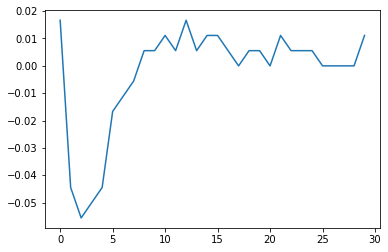

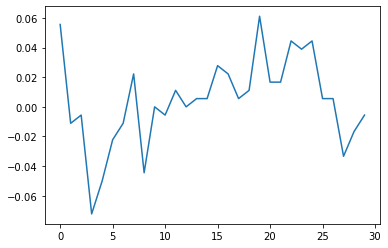

In [15]:
# accuracy contribution by variance explained by motion
list_acc_odor_residual = np.load(os.path.join(the_save_path,'odor_classification_accuracy_motion_residual_c2.npy'))
list_acc_odor_gt = np.load(os.path.join(the_save_path,'odor_classification_accuracy_gt_c2.npy'))
gain = list_acc_odor_residual-list_acc_odor_gt
plt.plot(np.squeeze(gain[0,:]))
plt.show()
plt.plot(np.squeeze(gain[1,:]))
plt.show()